In [1]:
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

In [ ]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    u = torch.rand(1)
    data_fn = lambda x, y: 1 * torch.sin(0.15 * u * 3.1415 * (x + y)) + 1
    latent_fn = data_fn(x, y)
    z = torch.round(latent_fn).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn

In [3]:
def constraint_function(x1, x2):
    return np.cos(x1)*np.cos(x2) - np.sin(x1)*np.sin(x2)

def indicator_function(c):
    #c - value of constraint at a particular (x1, x2)
    return 1 if c<=0.5 else 0

def objective_function(x1, x2):
    return np.cos(2*x1)*np.cos(x2) + np.sin(x1)  

In [15]:
# contourf plot of constraint function
range_x1 = np.linspace(0,6,20)
range_x2 = np.linspace(0,6,20)

X1, X2 = np.meshgrid(range_x1, range_x2)

C = constraint_function(X1, X2)

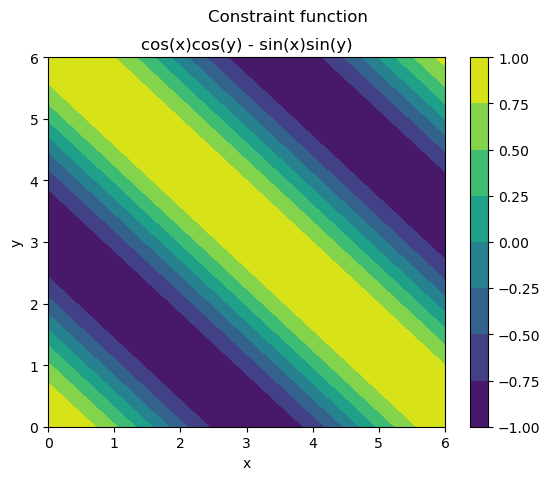

In [13]:
plt.contourf(X1, X2, C)
plt.xlabel("x")
plt.ylabel("y")
plt.suptitle("Constraint function")
plt.title("cos(x)cos(y) - sin(x)sin(y)")
plt.colorbar()
plt.show()

In [27]:
#prepare training data
train_points = 100
train_x1 = torch.randn(train_points, 1)
train_x2 = torch.randn(train_points, 1)
train_x = torch.cat((train_x1, train_x2), dim=1)
constraint_vals = constraint_function(train_x1, train_x2)
train_y = torch.tensor(np.array([indicator_function(i) for i in constraint_vals]))

In [10]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [11]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [31]:
# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [32]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 5.123   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 4.718   lengthscale: 0.826   noise: 0.488
Iter 11/50 - Loss: 4.483   lengthscale: 0.804   noise: 0.327
Iter 16/50 - Loss: 4.319   lengthscale: 0.765   noise: 0.212
Iter 21/50 - Loss: 4.226   lengthscale: 0.716   noise: 0.141
Iter 26/50 - Loss: 4.168   lengthscale: 0.700   noise: 0.100
Iter 31/50 - Loss: 4.128   lengthscale: 0.722   noise: 0.074
Iter 36/50 - Loss: 4.102   lengthscale: 0.735   noise: 0.059
Iter 41/50 - Loss: 4.083   lengthscale: 0.741   noise: 0.048
Iter 46/50 - Loss: 4.069   lengthscale: 0.749   noise: 0.041


In [ ]:
#test data points